In [1]:
import pyspark

In [2]:
from pyspark.sql import SparkSession

In [3]:
Spark = SparkSession.builder.appName('practice').getOrCreate()

In [4]:
Spark

In [13]:
column_names = ['HCHO Reading', 'Location', 'Current Date', 'Next Date']
data_frame = Spark.read.csv('C:/Users/MSI KATANA/Desktop/practice ML/data engineering cw by inupa B/Data-Engineering-HCHO-gas-prediction-/col_mat_nuw_output.csv', header=None, inferSchema=True)
# Assign column names
data_frame = data_frame.toDF(*column_names)

# Show the DataFrame
data_frame.show()


+--------------------+--------------+------------+----------+
|        HCHO Reading|      Location|Current Date| Next Date|
+--------------------+--------------+------------+----------+
|1.969834395781014...|Colombo Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|  2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|  2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|  2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|  2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|  2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|  2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|  2019-01-12|2019-01-13|
|                NULL|Colombo Proper|  2019-01-13|2019-01-14|
|1.33629

In [17]:
# Assuming data_frame is your DataFrame

# Get the number of rows
num_rows = data_frame.count()

# Get the number of columns
num_columns = len(data_frame.columns)

# Print the shape
print("Shape of the DataFrame: {} rows, {} columns".format(num_rows, num_columns))


Shape of the DataFrame: 5478 rows, 4 columns


In [14]:
data_frame.printSchema()

root
 |-- HCHO Reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: date (nullable = true)
 |-- Next Date: date (nullable = true)



In [16]:
from pyspark.sql.functions import col, sum as spark_sum, when

columns = data_frame.columns

# Calculate missing values for each column
missing_counts = data_frame.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in columns])

# Show missing counts
missing_counts.show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|        2419|       0|           0|        0|
+------------+--------+------------+---------+



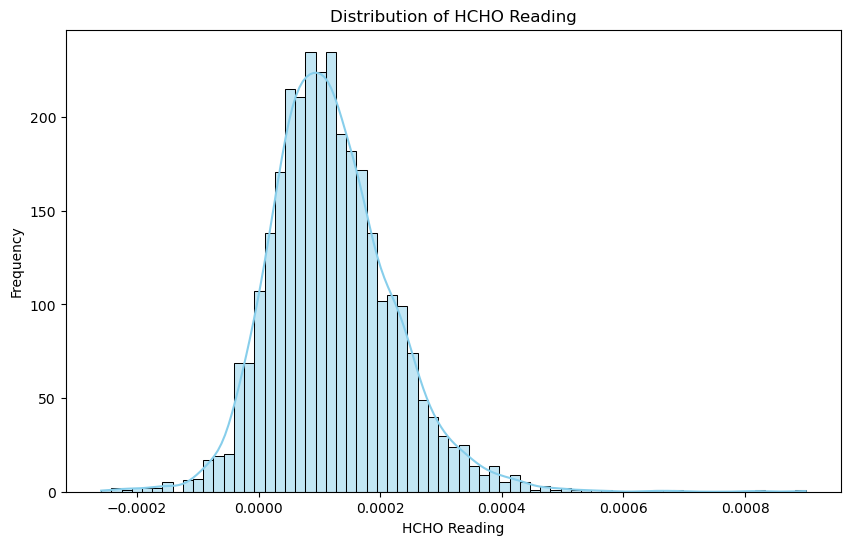

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the "HCHO Reading" column to a Pandas DataFrame for visualization
hcho_df = data_frame.select("HCHO Reading").toPandas()

# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(hcho_df["HCHO Reading"], kde=True, color='skyblue')
plt.title('Distribution of HCHO Reading')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.show()


In [31]:
from pyspark.sql.window import Window
from pyspark.sql.functions import coalesce, col, lag, lead, count

# Initialize a counter for null values
null_count = data_frame.filter(col("HCHO Reading").isNull()).count()

# Continue the process until there are no nulls left
while null_count > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("Current Date")
    forward_windowSpec = Window.orderBy("Current Date")
    
    # Use lag to carry the last observation forward
    previous_value = lag("HCHO Reading", 1).over(backward_windowSpec)
    data_frame = data_frame.withColumn("HCHO Reading", coalesce("HCHO Reading", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("HCHO Reading", 1).over(forward_windowSpec)
    data_frame = data_frame.withColumn("HCHO Reading", coalesce("HCHO Reading", next_value))
    
    # Update the null count
    null_count = data_frame.filter(col("HCHO Reading").isNull()).count()

# cmn_data now has the nulls filled using a combination of LOCF and NOCB

In [33]:
from pyspark.sql.functions import col, sum as spark_sum, when

columns = data_frame.columns

# Calculate missing values for each column
missing_counts = data_frame.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in columns])

# Show missing counts
missing_counts.show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|           0|       0|           0|        0|
+------------+--------+------------+---------+



data_frame.show()

# Importing second dataset Kandy

In [36]:
column_names = ['HCHO Reading', 'Location', 'Current Date', 'Next Date']
data_frame = Spark.read.csv('C:/Users/MSI KATANA/Desktop/practice ML/data engineering cw by inupa B/Data-Engineering-HCHO-gas-prediction-/kan_output.csv', header=None, inferSchema=True)
# Assign column names
data_frame_2 = data_frame.toDF(*column_names)

# Show the DataFrame
data_frame_2.show()

+--------------------+------------+------------+----------+
|        HCHO Reading|    Location|Current Date| Next Date|
+--------------------+------------+------------+----------+
|1.760713459877335...|Kandy Proper|  2019-01-01|2019-01-02|
|9.220391253917748E-5|Kandy Proper|  2019-01-02|2019-01-03|
|                NULL|Kandy Proper|  2019-01-03|2019-01-04|
|1.908681983853839...|Kandy Proper|  2019-01-04|2019-01-05|
|1.219517840206744...|Kandy Proper|  2019-01-05|2019-01-06|
|-6.51408612938880...|Kandy Proper|  2019-01-06|2019-01-07|
|  1.6323820639265E-4|Kandy Proper|  2019-01-07|2019-01-08|
|-6.73520553391426...|Kandy Proper|  2019-01-08|2019-01-09|
|1.279693658243135...|Kandy Proper|  2019-01-09|2019-01-10|
|4.546048424126012E-5|Kandy Proper|  2019-01-10|2019-01-11|
|3.600074175192105E-5|Kandy Proper|  2019-01-11|2019-01-12|
|1.286629698010177E-4|Kandy Proper|  2019-01-12|2019-01-13|
|                NULL|Kandy Proper|  2019-01-13|2019-01-14|
|                NULL|Kandy Proper|  201

In [37]:
# Get the number of rows
num_rows = data_frame_2.count()

# Get the number of columns
num_columns = len(data_frame_2.columns)

# Print the shape
print("Shape of the DataFrame: {} rows, {} columns".format(num_rows, num_columns))

Shape of the DataFrame: 1826 rows, 4 columns


In [38]:
data_frame_2.printSchema()

root
 |-- HCHO Reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: date (nullable = true)
 |-- Next Date: date (nullable = true)



In [39]:
from pyspark.sql.functions import col, sum as spark_sum, when

columns = data_frame_2.columns

# Calculate missing values for each column
missing_counts = data_frame_2.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in columns])

# Show missing counts
missing_counts.show()

+------------+--------+------------+---------+
|HCHO Reading|Location|Current Date|Next Date|
+------------+--------+------------+---------+
|         793|       0|           0|        0|
+------------+--------+------------+---------+



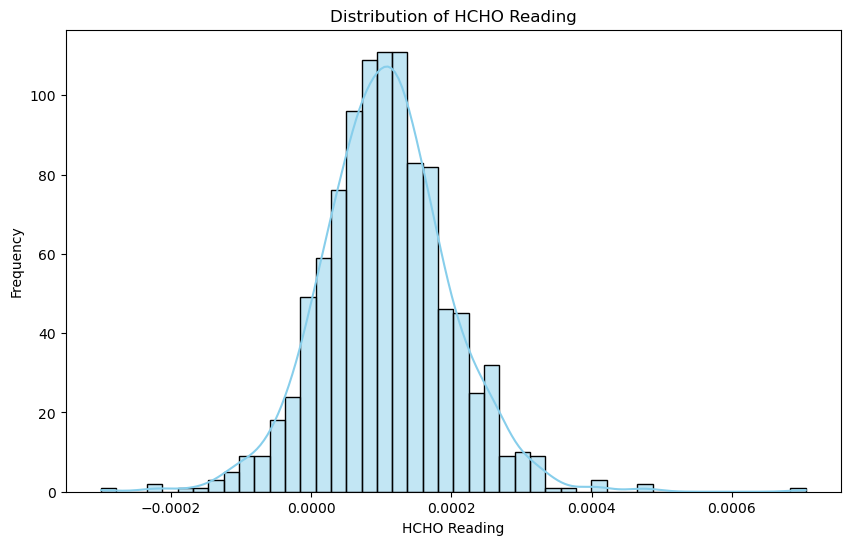

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the "HCHO Reading" column to a Pandas DataFrame for visualization
hcho_df_2 = data_frame_2.select("HCHO Reading").toPandas()

# Plot the distribution of the "HCHO Reading" column
plt.figure(figsize=(10, 6))
sns.histplot(hcho_df_2 ["HCHO Reading"], kde=True, color='skyblue')
plt.title('Distribution of HCHO Reading')
plt.xlabel('HCHO Reading')
plt.ylabel('Frequency')
plt.show()


In [41]:
from pyspark.sql.window import Window
from pyspark.sql.functions import coalesce, col, lag, lead, count

# Initialize a counter for null values
null_count_2 = data_frame_2.filter(col("HCHO Reading").isNull()).count()

# Continue the process until there are no nulls left
while null_count_2 > 0:
    # Define the window specifications
    backward_windowSpec = Window.orderBy("Current Date")
    forward_windowSpec = Window.orderBy("Current Date")
    
    # Use lag to carry the last observation forward
    previous_value = lag("HCHO Reading", 1).over(backward_windowSpec)
    data_frame_2 = data_frame_2.withColumn("HCHO Reading", coalesce("HCHO Reading", previous_value))
    
    # Use lead to carry the next observation backward
    next_value = lead("HCHO Reading", 1).over(forward_windowSpec)
    data_frame_2 = data_frame_2.withColumn("HCHO Reading", coalesce("HCHO Reading", next_value))
    
    # Update the null count
    null_count_2 = data_frame_2.filter(col("HCHO Reading").isNull()).count()

# cmn_data now has the nulls filled using a combination of LOCF and NOCB

In [ ]:
from pyspark.sql.functions import col, sum as spark_sum, when

columns_2 = data_frame_2.columns

# Calculate missing values for each column
missing_counts = data_frame.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in columns])

# Show missing counts
missing_counts.show()